## Sample 7.6 To derive stellar velocity distribution with hierarchical Bayesian model

In [68]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits

matplotlib.rc('xtick',labelsize=12)
matplotlib.rc('ytick',labelsize=12)


# read a sample velocity data
y = np.loadtxt('Vlos.dat')

# sampling
n = len(y)
print(n,np.min(y),np.max(y),np.median(np.abs(y-np.median(y))))
y_bar = np.mean(y)
s2 = np.var(y)
print(r'Data: y_bar = %(y).3f km/s,  s2 = %(s).3f km^2/s^2 s = %(s1).3f km/s' %\
     {'y':y_bar, 's':s2, 's1':np.sqrt(s2)})

294 -63.5 154.2 23.6
Data: y_bar = 14.260 km/s,  s2 = 1158.527 km^2/s^2 s = 34.037 km/s


### hierarchical models

#### ln_posterior1
This model only considers $\sigma$ with fixed $\mu=14$ km/s. $\sigma^2$ follows a scaled-Inverse-Chi$^2$ distribution with two hyperparameters, $\nu_0$ and $s^2$. As we will see, the model actually cannot constrain $\nu_0$ very well, while $s^2$ can be constrained tightly.

#### ln_posterior2
This is a model using a Gaussian distribution for $sigma^2$, which is actually wrong since in a Gaussian distribution, a negative value of $\sigma^2$ is also allowed.

#### ln_posterior3
In this model we consider that both $\sigma^2$ and $\mu$ of the group of the stars are unknown. $\mu$ follows a Gaussian dsistribution with additionally two hyperparameters, $mu_0$ and $\sigma_\mu$. Therefore, this is a 4-parameter hierarchical model.

In [202]:
import emcee
import corner


def ln_posterior1(x,v):
    nu0 = x[0]
    s2 = x[1]
    if (s2<=1) or (nu0<1) or (nu0>1e5):
        return -1e50
    sig2 = stats.invgamma.rvs(nu0/2.,scale=nu0*s2/2.,size=len(v))
    L = np.sum(-(v-14)**2/(2*sig2)-0.5*np.log(2.*np.pi)-0.5*np.log(sig2))
    return L

print(ln_posterior1([1e5,700],y))

def ln_posterior2(x,v):
    mu = x[0]
    s2 = x[1]
    if (s2<=1) or (mu<1):
        return -1e50
    sig2 = stats.norm.rvs(loc=mu,scale=s2,size=len(v))
    L = np.sum(-(v-14)**2/(2*sig2)-0.5*np.log(2.*np.pi)-0.5*np.log(sig2))
    return L

print(ln_posterior2([30**2,70],y))

def ln_posterior3(x,v):
    nu0 = x[0]
    s2 = x[1]
    mu0 = x[2]
    t2 = x[3]
    if (s2<=1) or (nu0<=1) or (nu0>1e5) or (t2<=0):
        return -1e50
    mu = stats.norm.rvs(loc=mu0,scale=t2,size=len(v))
    sig20 = stats.invgamma.rvs(nu0/2.,scale=nu0*s2/2.,size=len(v))
    L0 = np.sum(-(v-mu)**2/(2*sig20)-0.5*np.log(2.*np.pi)-0.5*np.log(sig20))
    
    return L0+1500

print(ln_posterior3([10,500,14,1],y))


-1476.6003088594398
-1459.5863951378883
-25.2146248256131


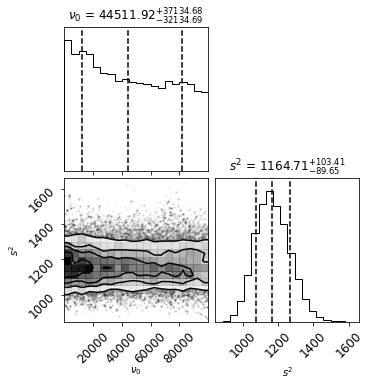

In [206]:
nwalker = 50
ndim = 2
p0 = np.zeros((nwalker,ndim))
p0[:,0] = np.random.rand(nwalker)*100.+100.
p0[:,1] = np.random.rand(nwalker)*35*35.+40.*40.
sampler = emcee.EnsembleSampler(nwalker, ndim, ln_posterior1,args=[y])
pos,prob,stat = sampler.run_mcmc(p0,100)
sampler.reset()
sampler.run_mcmc(pos,1000)
samples = sampler.chain[:, :, :].reshape((-1, ndim))
fig = corner.corner(samples,\
    labels=[r'$\nu_0$',r'$s^2$'],\
        quantiles=[0.16, 0.5, 0.84],\
        show_titles=True, \
        title_kwargs={"fontsize": 12})

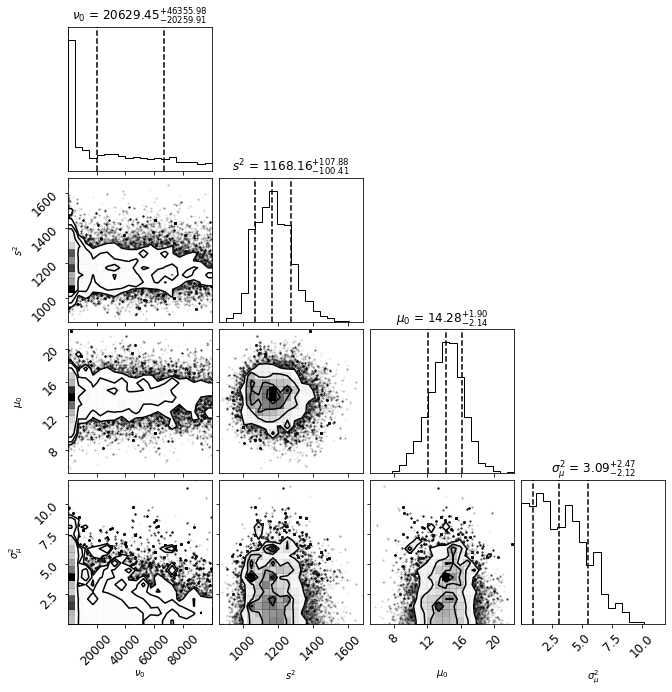

In [201]:
nwalker = 100
ndim = 4
p0 = np.zeros((nwalker,ndim))
p0[:,0] = np.random.rand(nwalker)*100.+100.
p0[:,1] = np.random.rand(nwalker)*35*35.+40.*40.
p0[:,2] = np.random.rand(nwalker)*50-25
p0[:,3] = np.random.rand(nwalker)*10+5
sampler = emcee.EnsembleSampler(nwalker, ndim, ln_posterior3,args=[y])
pos,prob,stat = sampler.run_mcmc(p0,100)
sampler.reset()
sampler.run_mcmc(pos,1000)
samples = sampler.chain[:, :, :].reshape((-1, ndim))
fig = corner.corner(samples,\
    labels=[r'$\nu_0$',r'$s^2$',r"$\mu_0$", r"$\sigma_\mu^2$"],\
        quantiles=[0.16, 0.5, 0.84],\
        show_titles=True, \
        title_kwargs={"fontsize": 12})

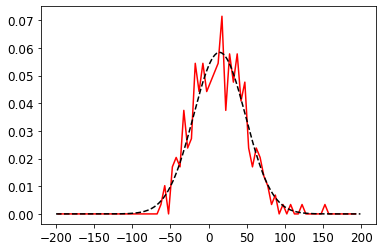

In [204]:
h,xedge = np.histogram(y,np.arange(-200,200,5))
plt.plot((xedge[1:]+xedge[:-1])/2.,h/np.sum(h),'r-')
x = np.arange(-200,200,1)
plt.plot(x,stats.norm.pdf(x,loc=14.28,scale=np.sqrt(1168))*5,'k--')